In [142]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/airport.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [143]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826402 entries, 0 to 1826401
Data columns (total 52 columns):
ANumber                         category
LastName                        category
FirstName                       category
DOB                             category
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  

In [144]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

In [145]:
df.tail()

,ANumber,LastName,FirstName,DOB,Status,Sex,Convictions,GangMember,ClassLvl,Age,...,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,air_LatitudeDecimalDegrees,air_LongitudeDecimalDegrees,air2_LatitudeDecimalDegrees,air2_LongitudeDecimalDegrees,NonCriminal
1826397,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,20.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826398,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,34.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826399,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,19.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826400,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8F,M,NC,N,NaN,33.0,...,NaN,NaN,NaN,NaN,Guatemala,25.907000,-97.426000,14.583,-90.528,True
1826401,(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),(B)(6);(B)(7)(C),8C,F,NC,N,NaN,24.0,...,NaN,NaN,NaN,NaN,Guatemala,33.307833,-111.655472,14.583,-90.528,True


# Specific airport

In [146]:
# Select records for an airport represented in the database using its 4-character ICAO code
airport = 'KELP'
airport = str(airport).upper()

In [147]:
airport_name = airport_dict[airport]['AirportName']

# Creating DataFrames for pickup and dropoff records.
# If memory usage is too great these can be deleted and assigned again as needed.
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport
pickup_df = df[pickup].copy()
dropoff_df = df[dropoff].copy()

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# DataFrame for all records relating to selected airport.
all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# DataFrames for all records categorized as removals, transfers.
removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal].copy()
transfer_df = all_df[transfer].copy()

# Names here are used downstream in figure labels.
all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Departures'
dropoff_df.name = 'Arrivals'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].count()

# Resampled counts of passengers and missions for different timeframes and types of record.
weekly_pickups = pickup_df['AlienMasterID'].resample('W').count()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').count()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').count()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').count()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').count()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').count()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').count()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').count()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').count()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
annual_total_missions = all_df['MissionID'].resample('AS-OCT').nunique()

# Various descriptive statistics for selected airport
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = unique_removals / total_unique * 100
transfer_percent = unique_transfers / total_unique * 100
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

In [148]:
total_unique

230505

In [19]:
annual_summary

,Annual Pickups,Annual Pickup Missions,Annual Dropoffs,Annual Dropoff Missions,Annual Removals,Annual Transfers,Annual Total Passengers,Annual Total Missions
Fiscal Year,,,,,,,,
2011,11823,367,6118,224,11483,6458,17941,431
2012,15793,365,10194,312,13380,12606,25986,440
2013,16520,288,9649,262,14806,11363,26169,386
2014,17656,255,15244,321,15609,17282,32891,450
2015,16921,254,12584,240,15757,13748,29505,344
2016,20874,289,13738,216,18284,16328,34612,367
2017,18027,244,8342,151,14467,11902,26369,301
2018,16709,226,9797,176,16583,9923,26506,290
2019,7026,109,3736,69,7123,3405,10528,135


In [149]:
annual_total

MissionDate
2010-10-01    17941
2011-10-01    25986
2012-10-01    26169
2013-10-01    32891
2014-10-01    29505
2015-10-01    34612
2016-10-01    26369
2017-10-01    26506
2018-10-01    10528
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [242]:
len(dropoff_df[dropoff_df['R-T'] == 'R'])

7305

In [245]:
dropoff_df.loc[dropoff_df['R-T'] == 'R', 'CountryOfCitizenship'].value_counts()

MEXICO                          7293
ECUADOR                           11
UNITED STATES OF AMERICA           1
POLAND                             0
SUDAN                              0
SRI LANKA                          0
SPAIN                              0
SOUTH KOREA                        0
SOMALIA                            0
SLOVAKIA                           0
RWANDA                             0
RUSSIA                             0
ROMANIA                            0
PORTUGAL                           0
PHILIPPINES                        0
SYRIA                              0
PERU                               0
PARAGUAY                           0
PANAMA                             0
PAKISTAN                           0
NIGERIA                            0
NIGER                              0
NICARAGUA                          0
NEW ZEALAND                        0
NEPAL                              0
MOZAMBIQUE                         0
SWEDEN                             0
A

In [243]:
len(dropoff_df[dropoff_df['R-T'] == 'T'])

82097

In [150]:
# Top destination airports for removals from selected airport
pickup_df[pickup_df['R-T'] == 'R']['air2_AirportName'].value_counts().head(10)

Licenciado Benito Juarez International Airport        67669
Valley International Airport                          21028
La Aurora Airport                                     15545
El Salvador International Airport                      7792
Ramon Villeda Morales International Airport            4079
Augusto C. Sandino (Managua) International Airport     2308
Laredo International Airport                            249
Phoenix-Mesa-Gateway Airport                            202
Indira Gandhi International Airport                     181
Aden Adde International Airport                         135
Name: air2_AirportName, dtype: int64

In [241]:
# Top sending airports for removals at selected airport
dropoff_df[dropoff_df['R-T'] == 'R']['air_AirportName'].value_counts().head(10)

Boeing Field King County International Airport    2301
Denver International Airport                      1676
San Diego International Airport                   1208
McCarran International Airport                    1126
Salt Lake City International Airport               351
Alexandria International Airport                   233
Phoenix-Mesa-Gateway Airport                       187
Miami International Airport                         73
City of Colorado Springs Municipal Airport          35
Reno Tahoe International Airport                    35
Name: air_AirportName, dtype: int64

In [151]:
# Top destination airports for transfers from selected airport
pickup_df[pickup_df['R-T'] == 'T']['air2_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            14705
San Antonio International Airport                        2401
Alexandria International Airport                         1454
Miami International Airport                               490
George Bush Intercontinental Houston Airport              298
Columbus Metropolitan Airport                             289
El Paso International Airport                             244
Memphis International Airport                             236
Valley International Airport                              211
Brownsville South Padre Island International Airport      176
Name: air2_AirportName, dtype: int64

In [240]:
# Top sending airports for transfers to selected airport
dropoff_df[dropoff_df['R-T'] == 'T']['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        12311
San Diego International Airport                         10757
Columbus Metropolitan Airport                           10370
Boeing Field King County International Airport           9230
Phoenix-Mesa-Gateway Airport                             6462
McCarran International Airport                           5862
Denver International Airport                             5814
Brownsville South Padre Island International Airport     5624
Valley International Airport                             3545
Salt Lake City International Airport                     2970
Name: air_AirportName, dtype: int64

In [152]:
missions_df = all_missions.reset_index()
missions_df = missions_df.rename({"AlienMasterID": "Passengers"}, axis=1)

In [153]:
missions_df.to_csv(f'../output/{airport}_missions.csv', index=False)

In [154]:
missions_df

,MissionDate,MissionID,PULOC,DropLoc,Passengers
0,2010-10-01,1695,KELP,KHRL,46
1,2010-10-01,1695,KELP,KIWA,1
2,2010-10-04,110,KSAN,KELP,4
3,2010-10-04,111,KELP,MSLP,29
4,2010-10-05,113,KELP,KHRL,26
5,2010-10-05,114,KELP,KIWA,5
6,2010-10-05,114,KSAN,KELP,24
7,2010-10-05,115,KELP,MGGT,23
8,2010-10-06,117,KELP,KHRL,54
9,2010-10-06,118,KELP,KIWA,10


# Annual trends (by fiscal year)

In [155]:
fy_index = pd.date_range(start='2010-10-01', end='2019-01-01', freq='AS-OCT')

In [156]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True)
annual_total_missions.rename('Total missions', inplace=True)

MissionDate
2010-10-01    431
2011-10-01    440
2012-10-01    386
2013-10-01    450
2014-10-01    344
2015-10-01    367
2016-10-01    301
2017-10-01    290
2018-10-01    135
Freq: AS-OCT, Name: Total missions, dtype: int64

In [157]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Dropoff Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total Passengers': annual_total,
              'Annual Total Missions': annual_total_missions}, index=fy_index)

In [158]:
annual_total_missions

MissionDate
2010-10-01    431
2011-10-01    440
2012-10-01    386
2013-10-01    450
2014-10-01    344
2015-10-01    367
2016-10-01    301
2017-10-01    290
2018-10-01    135
Freq: AS-OCT, Name: Total missions, dtype: int64

In [159]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [160]:
annual_summary = annual_summary.rename({2019: '2019*'})

In [161]:
flat_summary = annual_summary.unstack().to_frame().T 

In [162]:
flat_summary.index = [airport]

In [163]:
flat_summary.columns = flat_summary.columns.tolist()

In [234]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [165]:
# annual_dropoffs.to_csv(f'../output/{airport}-dropoffs.csv')

In [235]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()

    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    txt='*First 6 months\n(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(.9, 0, txt, wrap=True, horizontalalignment='right', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

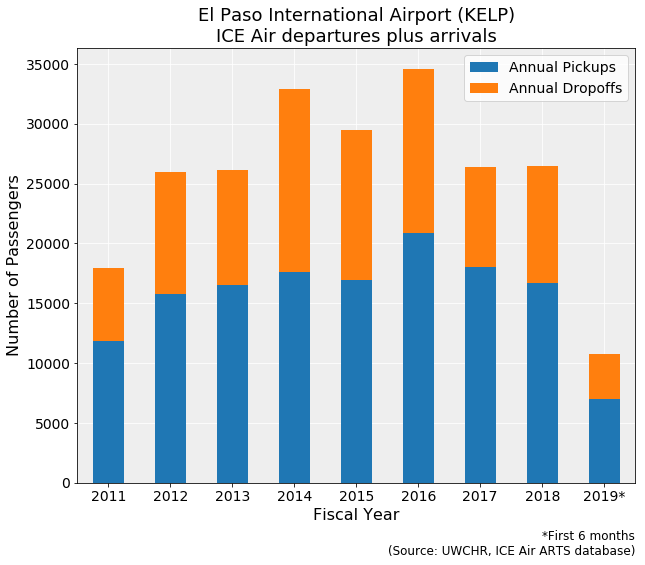

In [236]:
data = annual_summary[['Annual Pickups', 'Annual Dropoffs']]
title = f'{airport_name} ({airport})\nICE Air departures plus arrivals'
bar_chart(data, airport, airport_name, 'pickup-dropoff', title)
plt.show()

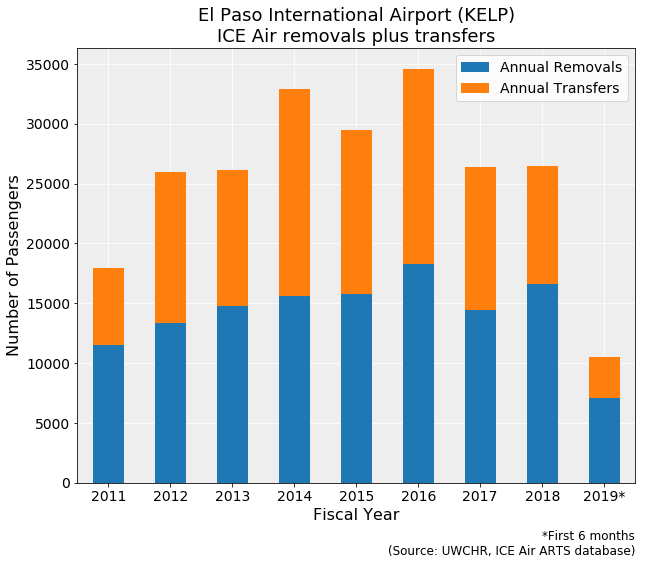

In [237]:
data = annual_summary[['Annual Removals', 'Annual Transfers']]
title = f'{airport_name} ({airport})\nICE Air removals plus transfers'
bar_chart(data, airport, airport_name, 'removal-transfer', title)
plt.show()

In [169]:
annual_summary[['Annual Pickups', 'Annual Dropoffs']].to_csv(f'../output/{airport}-AnnualDeparturesArrivals.csv')

In [170]:
# all_df.to_csv(f'../output/{airport}-allpassengers.csv')

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [171]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [172]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

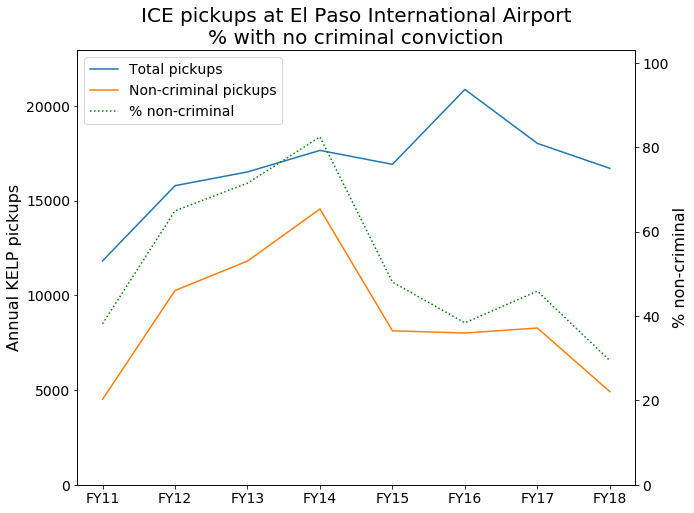

In [173]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.grid(None)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by FY)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

In [174]:
monthly_means = pd.DataFrame()
for year in range(2011, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [175]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2011,19.42,554.08,30.33,970.17
2012,28.83,1053.58,31.92,1601.75
2013,20.42,756.08,20.92,1216.17
2014,25.67,1205.08,21.25,1490.75
2015,19.67,1151.08,20.67,1409.83
2016,16.00,1011.17,25.83,1864.33
2017,13.83,745.50,19.17,1428.92
2018,13.17,747.75,16.92,1202.83


In [176]:
# monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [177]:
removal_df[removal_df['CountryOfCitizenship'] == 'EL SALVADOR']['DropLoc']

MissionDate
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-04    MSLP
2010-10-25    MSLP
              ... 
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP
2019-04-24    MSLP


In [178]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                90366
GUATEMALA             20902
EL SALVADOR           12056
HONDURAS               9769
NICARAGUA              2892
ECUADOR                1201
CUBA                    790
COLOMBIA                495
DOMINICAN REPUBLIC      342
INDIA                   267
Name: CountryOfCitizenship, dtype: int64

In [179]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         67224
EL SALVADOR     6913
GUATEMALA       5963
HONDURAS        4070
NICARAGUA       2177
Name: CountryOfCitizenship, dtype: int64

In [180]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         157590
GUATEMALA       26725
EL SALVADOR     18969
HONDURAS        13744
NICARAGUA        5060
Name: CountryOfCitizenship, dtype: int64

In [181]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [182]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [183]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [184]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [185]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = pickup_df.copy()
df_to_analyze.name = pickup_df.name

In [186]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [187]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [188]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [189]:
all_passenger_nationality_by_year.loc['2016':'2017'].T.dropna(how='all').to_csv('../output/kbfi_pickups_by_nationality.csv')

In [190]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [191]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    txt=plt.figtext(0.7, -0.00, txt, wrap=True, horizontalalignment='center', fontsize=12)
    lgd=plt.legend(fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_extra_artists=(lgd,txt), bbox_inches='tight')
    return fig, ax

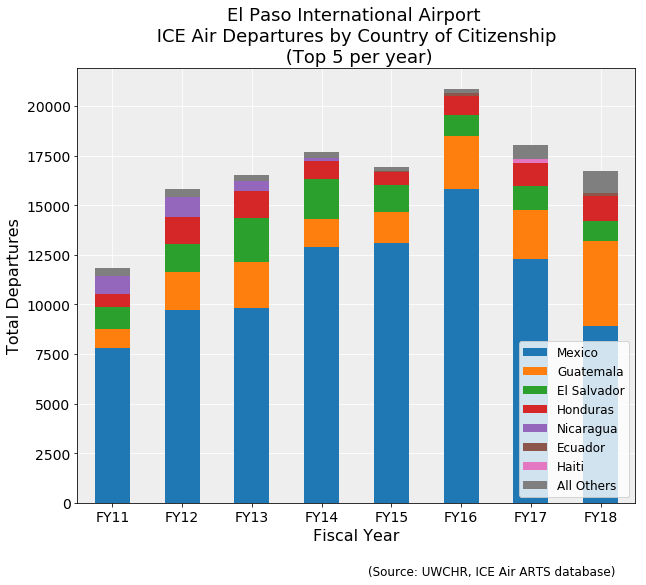

In [192]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [193]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary number of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [194]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [195]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)
annual = annual['2010':'2017']

In [196]:
# Select arbitrary number of top values to display here
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

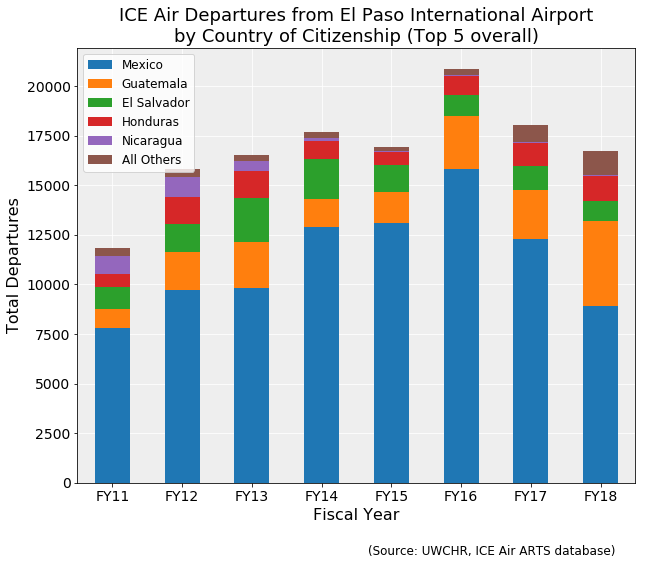

In [197]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air Departures from {airport_name}\nby Country of Citizenship (Top 5 overall)',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Not top nationalities

In [198]:
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

not_top_df = pd.DataFrame()
not_top_df = not_top_df.append(annual[~annual['CountryOfCitizenship'].isin(top)])
not_top_df.index = not_top_df.index.year

In [199]:
not_top_data = pd.pivot_table(data=not_top_df,
                       index=not_top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
not_top_data = not_top_data.reindex(not_top_data.sum().sort_values(ascending=False).index, axis=1)
# cols = list(not_top_data.columns)
# cols.remove('ALL OTHERS')
# cols.append('ALL OTHERS')
# not_top_data = not_top_data[cols]
# not_top_data.columns = not_top_data.columns.astype(str)
# not_top_data.columns = not_top_data.columns.str.title()

In [200]:
not_top_data.sum().head(15)

CountryOfCitizenship
ECUADOR               1000
COLOMBIA               481
DOMINICAN REPUBLIC     333
HAITI                  228
INDIA                  199
CAMBODIA               188
JAMAICA                178
SOMALIA                149
BRAZIL                 144
PAKISTAN               120
GUINEA                  84
GHANA                   76
BANGLADESH              76
NIGERIA                 64
CUBA                    58
dtype: int64

In [201]:
all_others = not_top_data.sum()[not_top_data.sum() < 50].index
greater_than_x = not_top_data.sum()[not_top_data.sum() > 50].index
to_plot = not_top_data[greater_than_x].copy()
to_plot.columns = to_plot.columns.astype(str)
to_plot['ALL OTHERS'] = not_top_data[all_others].sum(axis=1)
to_plot.index = [f'FY{str(x)[2:4]}' for x in to_plot.index + 1]

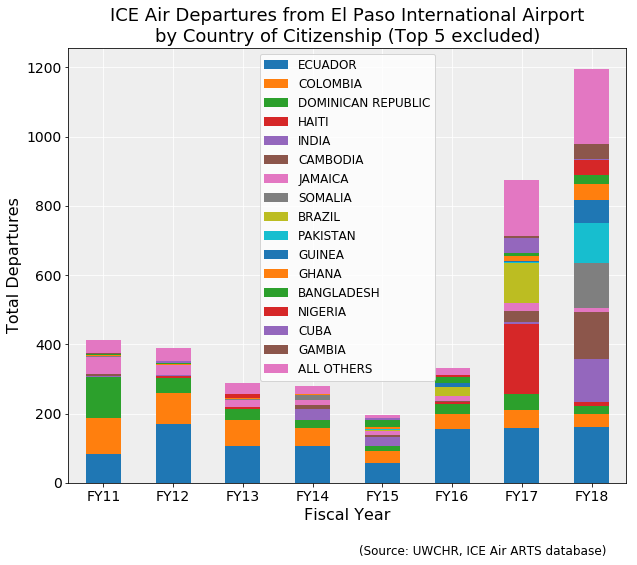

In [202]:
country_of_citizenship_trend(to_plot,
                             title=f'ICE Air Departures from {airport_name}\nby Country of Citizenship (Top 5 excluded)',
                             filename=f'{airport}_pickup_nationalities_top_5_excluded',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [203]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [204]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile           False  True   percent
PULOC MissionDate                       
KELP  2010-10-01   11778    45  0.382068
      2011-10-01   15750    43  0.273016
      2012-10-01   16509    11  0.066630
      2013-10-01   17637    19  0.107728
      2014-10-01   16825    96  0.570579
      2015-10-01   20476   398  1.943739
      2016-10-01   17194   833  4.844713
      2017-10-01   16672    35  0.209933
      2018-10-01    7000    26  0.371429

In [205]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [206]:
juvenile_pickups

Juvenile               False   True 
DropLoc MissionDate                 
KELP    2010-10-01    6111.0     7.0
        2011-10-01   10171.0    23.0
        2012-10-01    9595.0    54.0
        2013-10-01   12785.0  2459.0
        2014-10-01   12140.0   444.0
        2015-10-01   13738.0     NaN
        2016-10-01    8342.0     NaN
        2017-10-01    9794.0     3.0
        2018-10-01    3735.0     1.0

In [207]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile               False    True    percent
DropLoc MissionDate                            
KELP    2010-10-01    6111.0     7.0   0.114548
        2011-10-01   10171.0    23.0   0.226133
        2012-10-01    9595.0    54.0   0.562793
        2013-10-01   12785.0  2459.0  19.233477
        2014-10-01   12140.0   444.0   3.657331
        2015-10-01   13738.0     NaN        NaN
        2016-10-01    8342.0     NaN        NaN
        2017-10-01    9794.0     3.0   0.030631
        2018-10-01    3735.0     1.0   0.026774

In [208]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [209]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

Juvenile           False   True 
R-T MissionDate                 
R   2010-10-01   11447.0    36.0
    2011-10-01   13371.0     9.0
    2012-10-01   14798.0     8.0
    2013-10-01   15600.0     9.0
    2014-10-01   15735.0    22.0
    2015-10-01   18276.0     8.0
    2016-10-01   14449.0    18.0
    2017-10-01   16545.0    38.0
    2018-10-01    7096.0    27.0
T   2010-10-01    6442.0    16.0
    2011-10-01   12549.0    57.0
    2012-10-01   11306.0    57.0
    2013-10-01   14813.0  2469.0
    2014-10-01   13230.0   518.0
    2015-10-01   15938.0   390.0
    2016-10-01   11087.0   815.0
    2017-10-01    9921.0     NaN
    2018-10-01    3405.0     NaN

# Detainee status

In [210]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [211]:
status = pd.read_csv('../../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [212]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')
print(f"{sum(removal_df['Status'].isin(pending))} with pending appeals.")
print(f"{sum(removal_df['Status'].isin(benefit))} with benefit blocking deportation.")
print(f"{sum(removal_df['Status'].isin(expedited_admin_rein))} under expedited, administrative, reinstatement of removal.")

KELP - El Paso International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

85616 valid values.
41876 invalid values.

[1A]: 1969 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 101 (Voluntary Departure - Extended Departure Period)
[1C]: 2 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *263* (Deportable – Under Adjudication by IJ)
[2B]: *9* (Deportable – Under Adjudication by BIA)
[3]: 2634 (Deportable – Administratively Final Order)
[5A]: 1 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 23 (Removable – ICE Fugitive)
[5C]: *2* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *14* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 7 (Relief Granted – Extended Voluntary Departure)
[5F]: 14 (Unable to Obtain Travel Document)
[8A]: *185* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *354* (Exclu

In [213]:
sum(removal_df['Status'].isin(expedited_admin_rein))

62112

In [214]:
sum(removal_df['Status'].isin(pending))

844

In [215]:
sum(removal_df['Status'].isin(benefit))

16

In [216]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [217]:
total

MissionDate
2010-10-01    11483
2011-10-01    13380
2012-10-01    14806
2013-10-01    15609
2014-10-01    15757
2015-10-01    18284
2016-10-01    14467
2017-10-01    16583
2018-10-01     7123
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [218]:
transfer_status = transfer_df['Status'].value_counts()

In [219]:
transfer_status[transfer_status >= 100]

16                29475
8C                17284
8F                12896
8G                 7597
11                 4516
NO STATUS          3375
NTA                3017
RM                 2898
3                  2847
1A                 2645
REMOVAL            2434
ER-TRANSFER        1998
8A                 1636
8B                 1069
2A                 1009
F/O - TRANSFER      982
REINSTATE           820
TRANSFER - NTA      782
TRANSFER - F/O      724
9                   711
NTA - TRANSFER      669
12                  576
8E                  383
NTA-TRANSFER        271
RR-TRANSFER         201
NTA-TRFD            192
5B                  161
NTA-NEW             152
TRANSFER            136
TRANSFER-NTA        135
RE-INSTATE          123
Name: Status, dtype: int64

In [220]:
pickup_transfer_status = pickup_df[pickup_df['R-T'] == 'T']['Status'].value_counts()

In [221]:
pickup_transfer_status[pickup_transfer_status > 100]

16            5198
8G            4817
8F            3808
RM            1696
8C            1464
8A            1259
REMOVAL        597
3              358
8B             353
NO STATUS      175
2A             143
RE-INSTATE     123
1A             121
11             111
NTA            103
Name: Status, dtype: int64

In [222]:
dropoff_status = dropoff_df['Status'].value_counts()
dropoff_status[dropoff_status > 1]

16                  26362
8C                  18201
8F                   9781
11                   4608
NO STATUS            3201
8G                   3181
NTA                  2919
1A                   2892
3                    2848
ER-TRANSFER          2203
REMOVAL              1916
RM                   1336
F/O - TRANSFER        982
REINSTATE             961
2A                    920
8B                    835
TRANSFER - NTA        763
9                     707
TRANSFER - F/O        687
NTA - TRANSFER        669
12                    579
8A                    445
8E                    422
NTA-TRANSFER          265
RR-TRANSFER           202
NTA-TRFD              192
5B                    153
NTA-NEW               152
TRANSFER-NTA          135
8H                     79
                    ...  
FULL VR                 9
5E                      9
E/R C/R                 6
B&B                     5
M                       5
FINAL ORDER             5
NTA/NO BOND             4
1           

## Finding most common day of week

In [223]:
all_df['MissionWeekday'] = all_df.index.weekday

In [224]:
index = range(0,7)

In [225]:
weekdays_2018 = all_df.loc['2018'].groupby(['MissionWeekday'])['MissionID'].nunique()

In [226]:
weekdays_2018 = weekdays_2018.reset_index()

In [227]:
weekdays_2018 = weekdays_2018.set_index('MissionWeekday')

In [228]:
weekdays_2018 = weekdays_2018.reindex(index=index)

In [229]:
weekdays_2018 = weekdays_2018.rename({'MissionID': 'Flights'}, axis=1)

In [230]:
weekdays_2018 = weekdays_2018.T
weekdays_2018.columns = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

In [231]:
weekdays_2018.fillna(0, inplace=True)

In [232]:
weekdays_2018

,M,Tu,W,Th,F,Sa,Su
Flights,24,96,26,63,52,1,1


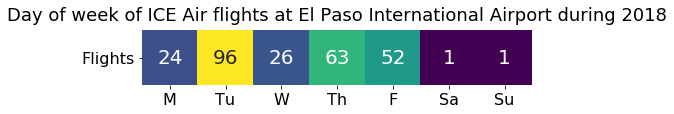

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(7,1)
ax = sns.heatmap(weekdays_2018, annot=True, annot_kws={"size": 20}, fmt='.0f', cmap=plt.cm.viridis, cbar=False)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, rotation=0)
# ax.set_ylabel('Year', fontsize=14)
# ax.set_xlabel('Weekday', fontsize=14)
ax.set_title(f'Day of week of ICE Air flights at {airport_name} during 2018', fontsize=18, pad=10);
# fig.savefig(f'../output/{airport}-weekdays.png', dpi=100,  bbox_inches='tight')